## Agroforestry Suitability Workflow

This notebook evaluates the **climate suitability** of agroforestry systems **at two scales**:

1. **Plot-specific analysis**  
   - Focused on a given plot location (latitude, longitude, elevation).  
   - Shows how suitability for each species may change **at this exact site** under future climate scenarios.

2. **Regional analysis**  
   - Looks at the wider production landscape around the plot.  
   - Maps current and projected suitability across the region.  
   - Puts the plot’s results in the context of where the crop or species is most likely to thrive.

---

### Workflow Overview

1. **Start from a plot**  
   - Define the plot location and record the current agroforestry system (species, density, shading, yield).

2. **Gather species occurrence data**  
   - Search GBIF and/or local datasets for occurrences in a **wider training region**.  
   - Clean, filter, and spatially thin to reduce bias.  
   - Optionally remove isolated or wild points if focusing on cultivated systems.

3. **Prepare environmental predictors**  
   - Load current climate data (e.g., TerraClimate).  

4. **Generate background (absence) points**  
   - Sample across the training region, restricted to land.  
   - Ensure coverage across environmental gradients (e.g., lowlands, highlands).

5. **Train the species distribution model (SDM)**  
   - Use a Random Forest classifier with presence/absence data.  
   - Evaluate performance (AUC, sensitivity, specificity).  
   - Determine a probability threshold for suitability.

6. **Predict suitability**  
   - For **current** climate conditions.  
   - For **future** climate scenarios.

7. **Analyse results**  
   - **Plot scale:** Extract suitability values for the exact plot location and compare now vs future.  
   - **Regional scale:** Map suitability categories (e.g., suitable both, newly suitable, no longer suitable) across the training region.

---

**Goal:**  
Provide decision‑makers with:
- **Actionable insights for their plot** (current system resilience, alternative scenarios).  
- **Regional context** to understand how local changes fit into broader production trends.


In [1]:
import pandas as pd
from config import DATA_DIR

# Path to your cleaned observation file
obs_path = DATA_DIR / "species_occurrences_combined_cleaned.csv"

# Read file
df_obs = pd.read_csv(obs_path)

# Normalise column names
rename_map = {
    "species": "species_query", "scientificName": "species_query",
    "Longitude": "decimalLongitude", "lon": "decimalLongitude", "lng": "decimalLongitude",
    "Latitude": "decimalLatitude",   "lat": "decimalLatitude",
}
for k, v in rename_map.items():
    if k in df_obs.columns and v not in df_obs.columns:
        df_obs = df_obs.rename(columns={k: v})

# Drop rows with no species info
df_obs = df_obs.dropna(subset=["species_query"])

# Get unique species
unique_species = sorted(df_obs["species_query"].unique())

# Show as list
for sp in unique_species:
    print(sp)

print(f"\nTotal unique species: {len(unique_species)}")


Annona muricata
Artocarpus altilis
Byrsonima crassifolia
Cajanus cajan
Carica papaya
Cedrela odorata
Citrus aurantium
Citrus sinensis
Coffea arabica
Cordia alliodora
Erythrina poeppigiana
Gliricidia sepium
Inga edulis
Inga jinicuil
Inga vera
Macadamia integrifolia
Mangifera indica
Musa paradisiaca
Persea americana
Pouteria sapota
Psidium guajava
Spondias mombin
Swietenia macrophylla
Theobroma cacao

Total unique species: 24


In [2]:
import numpy as np
import pandas as pd

def clean_occurrences(df, max_isolate_distance_deg=0.5, thinning_deg=2.5/60):
    """
    Clean occurrence points per species by:
    1. Removing isolated points farther than `max_isolate_distance_deg` from all others.
    2. Applying spatial thinning so that only 1 point is kept per grid cell of size `thinning_deg`.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns: species (or species_query), decimalLongitude, decimalLatitude.
    max_isolate_distance_deg : float
        Maximum allowed distance (in degrees) for a point to have a neighbour. 
        Points farther than this from all others are removed.
    thinning_deg : float
        Grid cell size for thinning, in degrees. Default 2.5 arc‑min (~0.0416667°).

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame of occurrences.
    """

    def remove_isolated_points(species_df):
        coords = species_df[["decimalLongitude", "decimalLatitude"]].to_numpy()
        keep_idx = []
        for i, c in enumerate(coords):
            dists = np.sqrt((coords[:,0] - c[0])**2 + (coords[:,1] - c[1])**2)
            dists[i] = np.inf  # ignore self
            if np.any(dists < max_isolate_distance_deg):
                keep_idx.append(i)
        return species_df.iloc[keep_idx]

    def thin_points(species_df):
        # Assign grid cell indices
        grid_x = np.floor(species_df["decimalLongitude"] / thinning_deg)
        grid_y = np.floor(species_df["decimalLatitude"] / thinning_deg)
        species_df = species_df.assign(grid_x=grid_x, grid_y=grid_y)
        # Randomly sample 1 point per grid cell
        thinned = species_df.groupby(["grid_x", "grid_y"], group_keys=False).apply(
            lambda g: g.sample(1, random_state=42)
        )
        return thinned.drop(columns=["grid_x", "grid_y"])

    cleaned_species_list = []
    for species, group in df.groupby("species_query" if "species_query" in df.columns else "species"):
        # 1️⃣ Remove extreme isolates
        non_isolated = remove_isolated_points(group)
        # 2️⃣ Apply spatial thinning
        thinned = thin_points(non_isolated)
        print(f"{species}: {len(group)} → {len(thinned)} after cleaning")
        cleaned_species_list.append(thinned)

    return pd.concat(cleaned_species_list, ignore_index=True)


# --- Example use ---
df = clean_occurrences(
    df_obs,
    max_isolate_distance_deg=0.1,   # ~11 km
    thinning_deg=2.5/60             # 2.5 arc-min (~4.6 km)
)

print(f"✅ Cleaned dataset: {len(df)} records")


Annona muricata: 1190 → 530 after cleaning
Artocarpus altilis: 1211 → 586 after cleaning
Byrsonima crassifolia: 3564 → 1861 after cleaning
Cajanus cajan: 469 → 255 after cleaning
Carica papaya: 2610 → 1399 after cleaning
Cedrela odorata: 2601 → 1203 after cleaning
Citrus aurantium: 256 → 103 after cleaning
Citrus sinensis: 488 → 162 after cleaning
Coffea arabica: 4014 → 1897 after cleaning
Cordia alliodora: 1976 → 841 after cleaning
Erythrina poeppigiana: 362 → 122 after cleaning
Gliricidia sepium: 2117 → 1092 after cleaning
Inga edulis: 8580 → 4663 after cleaning
Inga jinicuil: 289 → 107 after cleaning
Inga vera: 3172 → 1538 after cleaning
Macadamia integrifolia: 10 → 1 after cleaning
Mangifera indica: 2380 → 1149 after cleaning
Musa paradisiaca: 487 → 224 after cleaning
Persea americana: 2681 → 1349 after cleaning
Pouteria sapota: 545 → 237 after cleaning
Psidium guajava: 3938 → 1966 after cleaning
Spondias mombin: 1632 → 666 after cleaning
Swietenia macrophylla: 1096 → 473 after cle

In [3]:
df

,species_query,decimalLongitude,decimalLatitude,year,source
0,Annona muricata,-106.682167,24.415475,2023.0,GBIF
1,Annona muricata,-106.423805,23.193857,2020.0,GBIF
2,Annona muricata,-106.429925,23.232595,2023.0,GBIF
3,Annona muricata,-106.423988,23.260112,2022.0,GBIF
4,Annona muricata,-106.443430,23.299000,2015.0,GBIF
...,...,...,...,...,...
23128,Theobroma cacao,11.387600,4.149200,NaN,GBIF
23129,Theobroma cacao,11.418300,4.113200,NaN,GBIF
23130,Theobroma cacao,11.447400,4.148400,NaN,GBIF
23131,Theobroma cacao,11.958300,3.291700,NaN,GBIF


In [4]:
occ_all = df.rename(columns={"species_query":"species",
    "decimalLongitude": "lon",
    "decimalLatitude": "lat",
})[["species", "lon", "lat"]].dropna()


### Building the training dataset for suitability modelling

In this step, we prepare the **input dataset** that will be used to train the suitability model for each target species.

**Workflow:**

1. **Load climate predictors**
   - Open the `bio_stack` from TerraClimate (1990–2014 baseline).
   - This contains gridded bioclimatic variables such as temperature, precipitation, PET, AET, and solar radiation.
   - The file is an `xarray.Dataset`, which allows fast spatial extraction.

2. **Define modelling extent**
   - Specify the bounding box (`bbox`) for the study region.
   - This ensures we only extract presence and background points from within the relevant spatial domain.

3. **Select predictors**
   - Choose which climate variables to use for model training.
   - Selected variables can be adjusted depending on the research question and collinearity checks.

4. **Build the training dataset**  
   - Call `build_training_dataset()`:
     - Filters the presence dataset (`occ_all`) to the study area.
     - Generates background (pseudo‑absence) points within the study area.
     - Extracts climate predictor values for all points from `bio_stack`.
     - Combines presence (label = 1) and background (label = 0) into a single DataFrame.

5. **Result**
   - The resulting `data_all` contains:
     - Geographic coordinates.
     - Selected climate predictor values.
     - Presence/absence labels.
     - Species identifiers.
   - This is the core dataset for training species distribution models.

**Notes:**
- The `background_ratio` parameter controls how many background points are generated relative to the number of presences (here: 3×).
- This step **does not yet fit the model** — it only prepares the inputs.
- The presence dataset (`occ_all`) should be cleaned before this step (e.g., remove duplicates, isolates, and apply spatial thinning if needed).


In [5]:
from utils_suitability_modelling import build_training_dataset

import xarray as xr

# 📂 Path to your climate predictor stack
bio_path = DATA_DIR / "terra_climate/SuitabilityVariables_1990_2014.nc"

# 1️⃣ Open dataset
bio_stack = xr.open_dataset(bio_path)




# 📋 Inputs
bbox = (-115, -50, 10, 25)  # adjust to your study area

selected_predictors = [
    "MeanDiurnalRange",
    "Isothermality",
    "PrecSeasonality",
    "AnnualPET",
    "MeanTempDriestQuarter",
    "PrecDriestMonth",
    "PrecWettestMonth",
    "AnnualAET",
    "AnnualDeficit",
    "MeanSRAD",
    "MeanTempWettestQuarter",
    "PrecWarmestQuarter",
    "PrecColdestQuarter",
]
#bio_stack = bio_stack.rename({"lon": "y", "lat": "x"})

# 📂 Run
data_all = build_training_dataset(
    presence_df=occ_all,       # df with ['species', 'lon', 'lat']
    bio_stack=bio_stack,       # xarray.Dataset of your climate variables
    bbox=bbox,
    selected_predictors=selected_predictors,
    background_ratio=3
)

data_all.head()


✅ Found 15959 presence points in study area.


/Users/szelie/python_projects/biofincas_climate_risk/utils_suitability_modelling.py:75: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  land = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


🚀 Querying predictors for 40094 points…
🎉 Final dataset: 20877 records.
presence
1    15877
0     5000
Name: count, dtype: int64
species
background                5000
Coffea arabica            1721
Psidium guajava           1682
Carica papaya             1388
Byrsonima crassifolia     1339
Inga vera                 1155
Persea americana          1072
Mangifera indica          1057
Gliricidia sepium         1023
Inga edulis                867
Cedrela odorata            749
Cordia alliodora           615
Artocarpus altilis         552
Theobroma cacao            499
Annona muricata            456
Spondias mombin            373
Cajanus cajan              254
Swietenia macrophylla      230
Pouteria sapota            225
Musa paradisiaca           222
Citrus sinensis            146
Citrus aurantium           103
Inga jinicuil               88
Erythrina poeppigiana       60
Macadamia integrifolia       1
Name: count, dtype: int64


,MeanDiurnalRange,Isothermality,PrecSeasonality,AnnualPET,MeanTempDriestQuarter,PrecDriestMonth,PrecWettestMonth,AnnualAET,AnnualDeficit,MeanSRAD,MeanTempWettestQuarter,PrecWarmestQuarter,PrecColdestQuarter,lon,lat,presence,species
0,14.358133,59.493384,116.494341,1556.236,23.819067,0.592,298.744,852.916,703.320,207.840000,27.470533,455.520,58.476,-106.682167,24.415475,1,Annona muricata
1,9.263100,51.614215,132.873966,1550.084,22.590733,0.000,296.036,769.496,780.588,211.907333,29.022467,564.056,24.336,-106.423805,23.193857,1,Annona muricata
2,9.507167,52.329187,132.011151,1580.628,22.887733,0.168,291.924,766.388,814.240,211.205667,29.344000,553.904,24.556,-106.429925,23.232595,1,Annona muricata
3,9.812033,53.304251,130.981796,1570.816,22.916800,0.168,285.504,756.404,814.412,208.967333,29.335133,541.484,24.608,-106.423988,23.260112,1,Annona muricata
4,10.136067,55.078937,130.956449,1572.300,23.064933,0.172,282.452,748.688,823.612,210.115333,29.106733,522.076,27.920,-106.443430,23.299000,1,Annona muricata


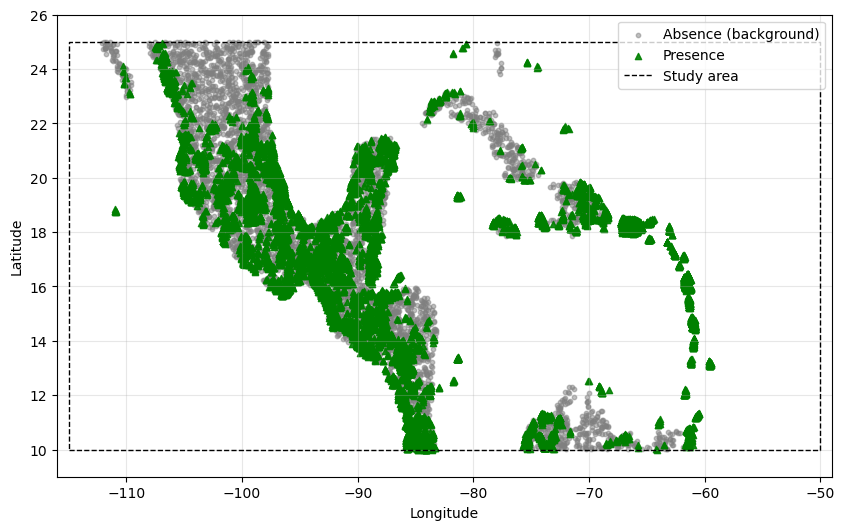

In [6]:
import matplotlib.pyplot as plt


lon_min, lon_max, lat_min, lat_max = bbox

# 📋 Separate presence & absence
presences = data_all[data_all["presence"] == 1]
absences  = data_all[data_all["presence"] == 0]

plt.figure(figsize=(10, 6))

# Background points (absence)
plt.scatter(
    absences["lon"], absences["lat"],
    color="grey", alpha=0.5, s=10, label="Absence (background)"
)

# Presence points
plt.scatter(
    presences["lon"], presences["lat"],
    color="green", alpha=0.9, s=20, marker='^', label="Presence"
)

# Study area bbox
plt.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color="black", linestyle="--", linewidth=1, label="Study area"
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim(lon_min - 1, lon_max + 1)
plt.ylim(lat_min - 1, lat_max + 1)
plt.grid(True, alpha=0.3)
plt.show()


## --> our points are quite sparce for the DR, we would need more observations ideally

## Species Suitability Modelling with Random Forest

The following cell trains **Random Forest** models to predict habitat suitability for multiple species based on environmental predictors.  
It uses **presence/background points**, applies filtering to remove correlated and redundant predictors, and evaluates model performance.

### Workflow
1. **Input Data**
   - `data_all` must contain:
     - `species` — species name
     - `presence` — binary presence/background label (`1` = presence, `0` = background)
     - `lon`, `lat` — coordinates in decimal degrees
     - Environmental predictors matching `selected_predictors`

2. **Settings**
   - `species_to_plot` — species for which to plot feature importance
   - `min_distance_deg` — minimum distance between presence and background points
   - `corr_threshold` — maximum Pearson correlation allowed
   - `vif_threshold` — maximum Variance Inflation Factor allowed
   - `n_estimators` — number of trees in the Random Forest
   - `min_importance` — minimum RF importance to retain predictors

3. **Feature Selection**
   - **Correlation filter**: remove highly correlated predictors
   - **VIF filter**: remove predictors with high multicollinearity
   - **Low-importance filter**: remove features with low RF importance

4. **Model Training**
   - Filter background points to be at least `min_distance_deg` from presence points
   - Split into train/test sets (70/30, stratified)
   - Train Random Forest
   - Retrain after removing low-importance predictors

5. **Evaluation**
   - Compute **AUC** (Area Under ROC Curve)
   - Determine optimal threshold for **max sensitivity + specificity**
   - Plot feature importance for selected species

6. **Outputs**
   - AUC scores per species
   - Feature importance plots
   - Suitability predictions for each point
   - Dictionaries of:
     - `trained_classifiers`
     - `feature_columns` used per species
     - `results_by_species`
   - `df_all_results` with predictions for all species


In [38]:
import rasterio
from rasterio.windows import from_bounds
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from pathlib import Path

# 📂 Adjust this to your actual file path
forest_cover_dir = Path("/Users/szelie/data/unu/tree_cover")  # <- adjust
forest_cover_files = sorted(forest_cover_dir.glob("*.tif"))

# ✅ Your GeoDataFrame with lon/lat
gdf = data_all.copy()  # or whatever your current gdf is

def meters_to_degrees(meters):
    return meters / 111_000  # rough conversion at equator

def extract_forest_cover_at_point(lon, lat, raster_paths, plot_area_m2=4184):
    side_m = np.sqrt(plot_area_m2)
    buffer_deg = meters_to_degrees(side_m) / 2

    for path in raster_paths:
        try:
            with rasterio.open(path) as src:
                if not (src.bounds.left <= lon <= src.bounds.right and
                        src.bounds.bottom <= lat <= src.bounds.top):
                    continue

                bounds = (
                    lon - buffer_deg, lat - buffer_deg,
                    lon + buffer_deg, lat + buffer_deg
                )
                window = from_bounds(*bounds, transform=src.transform)
                data = src.read(1, window=window, masked=True)

                if data.count() > 0:
                    return float(data.mean())
        except Exception as e:
            print(f"⚠️ Failed for {path.name}: {e}")

    return np.nan

# 🛰 Assign forest cover to each point
forest_cover_vals = []
for _, row in gdf.iterrows():
    val = extract_forest_cover_at_point(
        row["lon"], row["lat"], forest_cover_files
    )
    forest_cover_vals.append(val)

gdf["forest_cover"] = forest_cover_vals

# ✅ Check results
n_total = len(gdf)
n_assigned = gdf["forest_cover"].notna().sum()
print(f"✅ Assigned forest cover to {n_assigned} of {n_total} points ({100 * n_assigned / n_total:.1f}%)")


✅ Assigned forest cover to 19244 of 20877 points (92.2%)


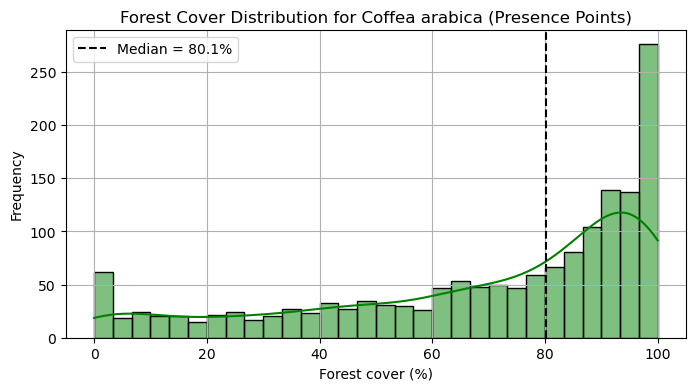

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to presence points for Coffea arabica
df_coffee = gdf[(gdf["species"] == "Coffea arabica") & (gdf["presence"] == 1)]
df_coffee =df_coffee[df_coffee.lon<-80]
# --- Forest cover ---
plt.figure(figsize=(8, 4))
sns.histplot(df_coffee["forest_cover"], bins=30, kde=True, color="green")

# Median line
median_fc = df_coffee["forest_cover"].median()
plt.axvline(median_fc, color="black", linestyle="--", label=f"Median = {median_fc:.1f}%")

plt.title("Forest Cover Distribution for Coffea arabica (Presence Points)")
plt.xlabel("Forest cover (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# --- Canopy height ---
if "canopy_height" in df_coffee.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_coffee["canopy_height"], bins=30, kde=True, color="brown")

    # Median line
    median_ch = df_coffee["canopy_height"].median()
    plt.axvline(median_ch, color="black", linestyle="--", label=f"Median = {median_ch:.1f} m")

    plt.title("Canopy Height Distribution for Coffea arabica (Presence Points)")
    plt.xlabel("Canopy height (m)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


In [87]:
np.nanquantile(df_coffee["forest_cover"], 0.2)

43.0


🌳 Training model for Coffea arabica — High forest (460 presences)
📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
✅ AUC (High forest): 0.974
🔁 Cross-validated AUCs (High forest): [0.804 0.895 0.986 0.949 0.8  ]
📊 Mean CV AUC (High forest): 0.887
🔀 Permutation test score: 0.887, p-value: 0.032


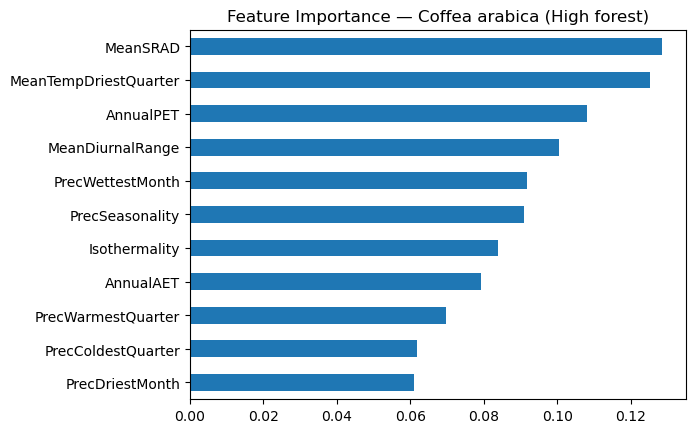


🌳 Training model for Coffea arabica — Low forest (474 presences)
📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
✅ AUC (Low forest): 0.975
🔁 Cross-validated AUCs (Low forest): [0.642 0.878 0.97  0.878 0.835]
📊 Mean CV AUC (Low forest): 0.840
🔀 Permutation test score: 0.840, p-value: 0.032


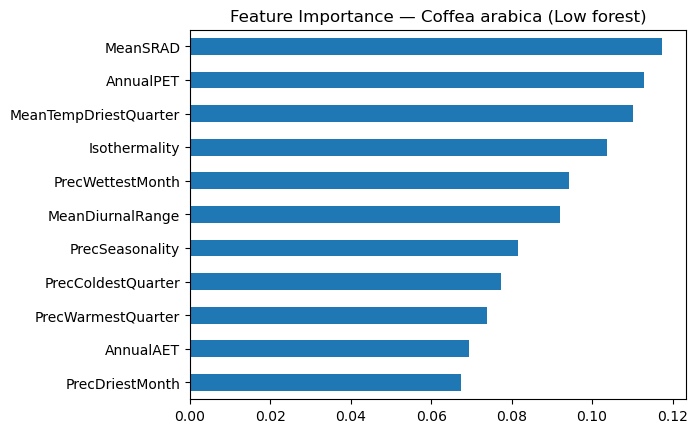


🌳 Training model for Coffea arabica — All data (1597 presences)
📉 Dropped correlated predictors: ['AnnualDeficit', 'MeanTempWettestQuarter']
✅ AUC (All data): 0.986
🔁 Cross-validated AUCs (All data): [0.776 0.931 0.989 0.943 0.865]
📊 Mean CV AUC (All data): 0.901
🔀 Permutation test score: 0.901, p-value: 0.032


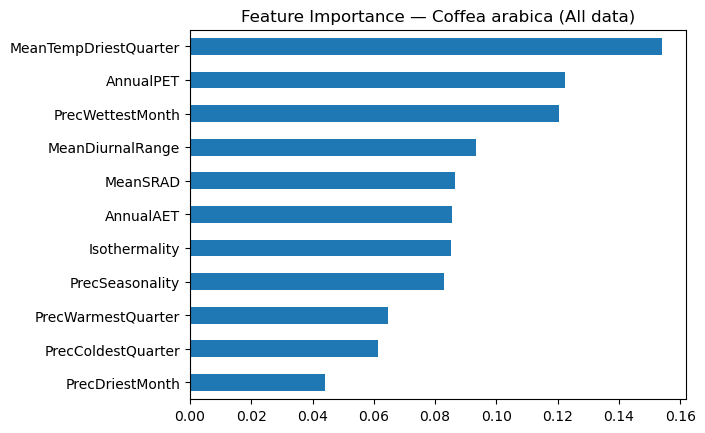

In [74]:
from sklearn.model_selection import train_test_split, cross_val_score, permutation_test_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# =========================================
# SETTINGS
# =========================================
species = "Coffea arabica"
min_distance_deg = 0.1
corr_threshold = 0.85
vif_threshold = 10
n_estimators = 300
min_importance = 0.01
  # Adjust if needed (percent forest cover)

selected_predictors = [
    "MeanDiurnalRange", "Isothermality", "PrecSeasonality", "AnnualPET",
    "MeanTempDriestQuarter", "PrecDriestMonth", "PrecWettestMonth", "AnnualAET",
    "AnnualDeficit", "MeanSRAD", "MeanTempWettestQuarter",
    "PrecWarmestQuarter", "PrecColdestQuarter"
]

threshold = {}
# =========================================
# UTILS
# =========================================
def drop_correlated(df, predictors, threshold=0.85):
    corr = df[predictors].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    keep = [p for p in predictors if p not in to_drop]
    return keep, to_drop

def calculate_vif(df, predictors):
    X = df[predictors].dropna()
    vif_data = pd.DataFrame()
    vif_data["feature"] = predictors
    vif_data["VIF"] = [sm.OLS(X[col], sm.add_constant(X.drop(columns=[col]))).fit().rsquared for col in X.columns]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])
    return vif_data

def drop_high_vif(df, predictors, threshold=10):
    vif_data = calculate_vif(df, predictors)
    to_drop = vif_data.loc[vif_data["VIF"] > threshold, "feature"].tolist()
    keep = [p for p in predictors if p not in to_drop]
    return keep, to_drop, vif_data

def max_sens_spec_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 101)
    best_thresh = 0.5
    best_score = -1
    for thr in thresholds:
        y_pred = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp / (tp + fn) if tp + fn > 0 else 0
        spec = tn / (tn + fp) if tn + fp > 0 else 0
        score = sens + spec
        if score > best_score:
            best_score = score
            best_thresh = thr
    return best_thresh

# =========================================
# TRAINING FOR HIGH, LOW, AND ALL FOREST COVER
# =========================================
trained_classifiers = {}
feature_columns = {}

df_background_all = data_all[(data_all["species"] == "background")].copy()

for forest_case, df_sub in {
    "High forest": df_coffee[df_coffee["forest_cover"] >  np.nanquantile(df_coffee["forest_cover"], 0.8)
],
    "Low forest": df_coffee[df_coffee["forest_cover"] <  np.nanquantile(df_coffee["forest_cover"], 0.2)
],
    "All data": df_coffee
}.items():

    if len(df_sub) < 10:
        print(f"⚠️ Not enough presence points for {forest_case}")
        continue

    print(f"\n🌳 Training model for {species} — {forest_case} ({len(df_sub)} presences)")

    # --- Background filtering ---
    pres_coords = df_sub[["lon", "lat"]].to_numpy()
    tree = cKDTree(pres_coords)
    bg_far = []
    for _, row in df_background_all.iterrows():
        dist, _ = tree.query([row["lon"], row["lat"]], k=1)
        if dist >= min_distance_deg:
            bg_far.append(row)
    df_background = pd.DataFrame(bg_far)

    df = pd.concat([df_sub, df_background], ignore_index=True)

    # --- Correlation filtering ---
    predictors_filtered, dropped_corr = drop_correlated(df, selected_predictors, corr_threshold)
    if dropped_corr:
        print(f"📉 Dropped correlated predictors: {dropped_corr}")

    # --- VIF filtering ---
    predictors_filtered, dropped_vif, vif_df = drop_high_vif(df, predictors_filtered, vif_threshold)
    if dropped_vif:
        print(f"📉 Dropped high-VIF predictors: {dropped_vif}")

    X = df[predictors_filtered]
    y = df["presence"]

    # --- Train/Test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # --- Train RF ---
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)

    # --- Drop low-importance features ---
    importances = pd.Series(clf.feature_importances_, index=predictors_filtered)
    low_imp = importances[importances < min_importance].index.tolist()
    if low_imp:
        print(f"📉 Dropping low-importance features: {low_imp}")
        predictors_filtered = [p for p in predictors_filtered if p not in low_imp]
        clf.fit(X_train[predictors_filtered], y_train)

    # --- Evaluate ---
    y_pred_prob = clf.predict_proba(X_test[predictors_filtered])[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"✅ AUC ({forest_case}): {auc:.3f}")

    # --- Cross-validation AUC ---
    cv_scores = cross_val_score(clf, X[predictors_filtered], y, cv=5, scoring='roc_auc')
    print(f"🔁 Cross-validated AUCs ({forest_case}): {cv_scores.round(3)}")
    print(f"📊 Mean CV AUC ({forest_case}): {cv_scores.mean():.3f}")

    # --- Permutation test ---
    score, perm_scores, pvalue = permutation_test_score(
        clf, X[predictors_filtered], y, scoring="roc_auc", cv=5, n_permutations=30, random_state=42
    )
    print(f"🔀 Permutation test score: {score:.3f}, p-value: {pvalue:.3f}")

    # --- Threshold ---
    threshold[forest_case] = max_sens_spec_threshold(y_test, y_pred_prob)

    # --- Feature importance plot ---
    importances = pd.Series(clf.feature_importances_, index=predictors_filtered).sort_values()
    importances.plot.barh()
    plt.title(f"Feature Importance — {species} ({forest_case})")
    plt.show()

    # --- Store classifier and features ---
    model_key = f"{species} — {forest_case}"
    trained_classifiers[model_key] = clf
    feature_columns[model_key] = predictors_filtered



In [73]:
threshold

'High forest'

## Predicting Suitability Maps for Current and Future Climate

This cell uses the **trained Random Forest models** to predict species suitability  
across the study area for **current** and **future** climate conditions.

### Steps
1. **Prepare data**
   - Use `df_now` (current climate) and `df_future` (future climate).
   - Drop rows with missing predictor values for each species’ selected features.

2. **Generate predictions**
   - For each trained classifier (`trained_classifiers`):
     - Extract the relevant predictors (`feature_columns[species]`).
     - Predict suitability **for each grid cell**.

3. **Estimate prediction uncertainty**
   - Run predictions for each individual decision tree in the Random Forest.
   - Compute:
     - **Mean suitability** (`suitability`)
     - **Standard deviation** across trees (`suitability_std`)

4. **Save results**
   - Store both mean and std for:
     - `suitability_maps_now[species]` — current climate
     - `suitability_maps_future[species]` — future climate
   - Each entry contains:
     - `lon`, `lat`
     - Mean suitability score
     - Prediction uncertainty (std)

### Output
- `suitability_maps_now`: dict of DataFrames with suitability & uncertainty for each species (current climate).
- `suitability_maps_future`: same as above for future climate.


In [75]:
import pandas as pd
import numpy as np
import xarray as xr

def load_and_crop_climate_data(nc_path, bbox):
    """
    Load a NetCDF climate dataset, ensure lat/lon ordering,
    crop to bounding box, and return as a DataFrame without NaNs.

    Parameters
    ----------
    nc_path : str
        Path to the NetCDF file.
    bbox : tuple
        (min_lon, max_lon, min_lat, max_lat) bounding box.

    Returns
    -------
    pd.DataFrame
        Climate data for the selected bounding box.
    """
    # 📂 Load dataset
    ds = xr.open_dataset(nc_path)

    # 🔄 Ensure lat ascending
    if ds.lat.values[0] > ds.lat.values[-1]:
        ds = ds.reindex(lat=list(reversed(ds.lat)))

    # 🔄 Ensure lon in -180..180 range
    if ds.lon.max() > 180:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)
    ds = ds.sortby("lon")

    # ✂️ Crop dataset to bbox
    lat_min, lat_max = sorted([bbox[2], bbox[3]])
    lon_min, lon_max = sorted([bbox[0], bbox[1]])
    ds_crop = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    # 🚿 Drop all-NaN grid cells
    ds_crop = ds_crop.dropna(dim="lat", how="all").dropna(dim="lon", how="all")

    # 📊 Convert to DataFrame
    df = ds_crop.to_dataframe().reset_index().dropna()

    return df

# 📍 Define bounding box
bbox = (-100.98, -80.0, 13.0, 21.98)

# 📄 Load current climate
df_now = load_and_crop_climate_data(
    "/Users/szelie/data/unu/terra_climate/SuitabilityVariables_1990_2014.nc",
    bbox
)

# 📄 Load future climate
df_future = load_and_crop_climate_data(
    "/Users/szelie/data/unu/terra_climate_scenarios_ncss/plus2C/SuitabilityVariables_plus2C_1990_2014.nc",
    bbox
)

# 📄 Load future climate
df_4c = load_and_crop_climate_data(
    "/Users/szelie/data/unu/terra_climate_scenarios_ncss/plus4C/SuitabilityVariables_plus4C_1990_2014.nc",
    bbox
)

print(f"✅ df_now: {len(df_now)} grid points, df_future: {len(df_future)} grid points")


✅ df_now: 45869 grid points, df_future: 45869 grid points


In [76]:
df_now

,lat,lon,MeanDiurnalRange,Isothermality,PrecSeasonality,AnnualPET,AnnualAET,AnnualDeficit,MeanSRAD,PrecDriestMonth,PrecWettestMonth,MeanTempDriestQuarter,MeanTempWettestQuarter,PrecWarmestQuarter,PrecColdestQuarter
321,13.020833,-87.604167,11.748367,80.202388,97.491929,1853.900,1156.272,697.628,244.669333,0.000,468.524,27.106067,27.233200,234.716,308.448
322,13.020833,-87.562500,11.768200,80.256697,96.878402,1835.696,1146.972,688.724,242.365000,0.000,464.932,27.050400,26.972067,205.376,350.140
323,13.020833,-87.520833,11.813400,79.008828,97.025370,1882.796,1150.792,732.004,242.332000,0.000,449.228,27.820267,27.537533,180.160,391.784
328,13.020833,-87.312500,12.036533,78.528493,95.895288,1920.616,1161.112,759.504,246.332000,0.000,435.768,27.783000,28.056333,299.136,252.468
329,13.020833,-87.270833,12.073600,79.142086,96.184306,1926.704,1163.540,763.164,245.414000,0.000,442.400,28.081733,28.077200,280.364,310.532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108859,21.979167,-80.187500,8.797233,61.357782,68.536356,1334.368,1112.820,221.548,230.719000,10.024,335.764,18.776200,23.142000,637.928,83.572
108860,21.979167,-80.145833,8.590900,59.668973,67.409921,1261.580,1098.088,163.492,229.618000,11.740,350.848,17.219133,21.929933,668.324,92.828
108861,21.979167,-80.104167,8.575833,59.156733,66.054148,1265.764,1109.756,156.008,229.635333,13.372,348.692,17.307867,22.078067,664.256,99.192
108862,21.979167,-80.062500,8.719633,59.793958,65.817597,1320.232,1131.192,189.040,231.189333,13.416,334.752,18.487000,23.145000,640.564,98.748


In [77]:
import pandas as pd
import numpy as np
import xarray as xr

def load_and_crop_climate_data(nc_path, bbox):
    ds = xr.open_dataset(nc_path)

    # 🔄 Ensure lat ascending
    if ds.lat.values[0] > ds.lat.values[-1]:
        ds = ds.reindex(lat=list(reversed(ds.lat)))

    # 🔄 Ensure lon in -180..180 range
    if ds.lon.max() > 180:
        ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)
    ds = ds.sortby("lon")

    # ✂️ Crop
    lat_min, lat_max = sorted([bbox[2], bbox[3]])
    lon_min, lon_max = sorted([bbox[0], bbox[1]])
    ds_crop = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

    ds_crop = ds_crop.dropna(dim="lat", how="all").dropna(dim="lon", how="all")
    df = ds_crop.to_dataframe().reset_index().dropna()
    return df

# 📍 Define bounding box
bbox = (-100.98, -80.0, 13.0, 21.98)

# 📄 Load current and future climate
df_now = load_and_crop_climate_data(
    "/Users/szelie/data/unu/terra_climate/SuitabilityVariables_1990_2014.nc", bbox
)
df_future = load_and_crop_climate_data(
    "/Users/szelie/data/unu/terra_climate_scenarios_ncss/plus2C/SuitabilityVariables_plus2C_1990_2014.nc", bbox
)

print(f"✅ df_now: {len(df_now)} points, df_future: {len(df_future)} points")

suitability_maps_now = {}
suitability_maps_future = {}
suitability_maps_4c = {}  # 4°C scenario

for species in trained_classifiers:
    clf = trained_classifiers[species]
    features = feature_columns[species]

    # Drop NaNs
    df_now_valid    = df_now.dropna(subset=features).copy()
    df_future_valid = df_future.dropna(subset=features).copy()
    df_4c_valid     = df_4c.dropna(subset=features).copy()

    # Prepare design matrices as NumPy (avoids the warning)
    X_now    = df_now_valid[features].to_numpy()
    X_future = df_future_valid[features].to_numpy()
    X_4c     = df_4c_valid[features].to_numpy()

    # NOW
    tree_preds_now = np.stack([tree.predict_proba(X_now)[:, 1] for tree in clf.estimators_], axis=1)
    df_now_valid["suitability"] = tree_preds_now.mean(axis=1)
    df_now_valid["suitability_std"] = tree_preds_now.std(axis=1)
    suitability_maps_now[species] = df_now_valid[["lon", "lat", "suitability", "suitability_std"]]

    # FUTURE (2°C)
    tree_preds_future = np.stack([tree.predict_proba(X_future)[:, 1] for tree in clf.estimators_], axis=1)
    df_future_valid["suitability"] = tree_preds_future.mean(axis=1)
    df_future_valid["suitability_std"] = tree_preds_future.std(axis=1)
    suitability_maps_future[species] = df_future_valid[["lon", "lat", "suitability", "suitability_std"]]

    # 4°C
    tree_preds_4c = np.stack([tree.predict_proba(X_4c)[:, 1] for tree in clf.estimators_], axis=1)
    df_4c_valid["suitability"] = tree_preds_4c.mean(axis=1)
    df_4c_valid["suitability_std"] = tree_preds_4c.std(axis=1)
    suitability_maps_4c[species] = df_4c_valid[["lon", "lat", "suitability", "suitability_std"]]


✅ df_now: 45869 points, df_future: 45869 points


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59882/221459967.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 0.95))


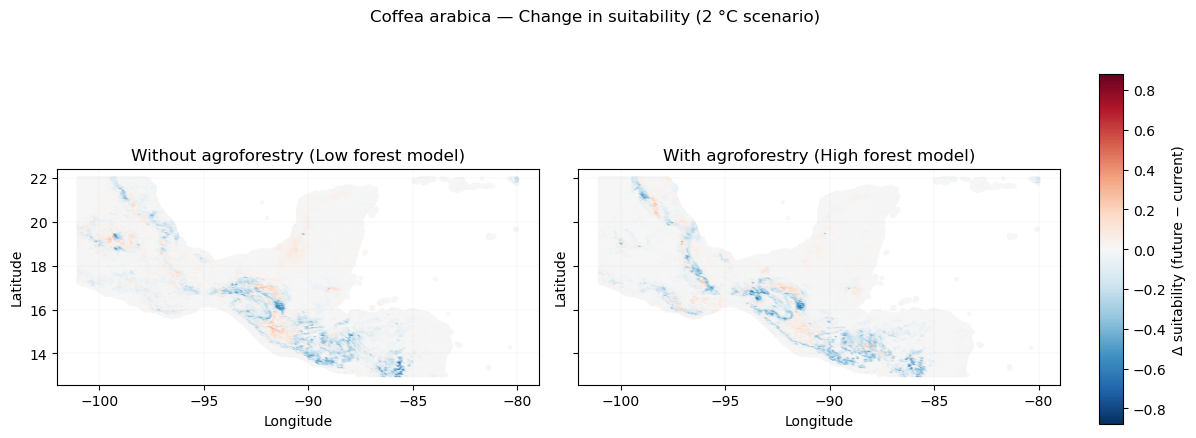

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_59882/221459967.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0, 0.9, 0.95))


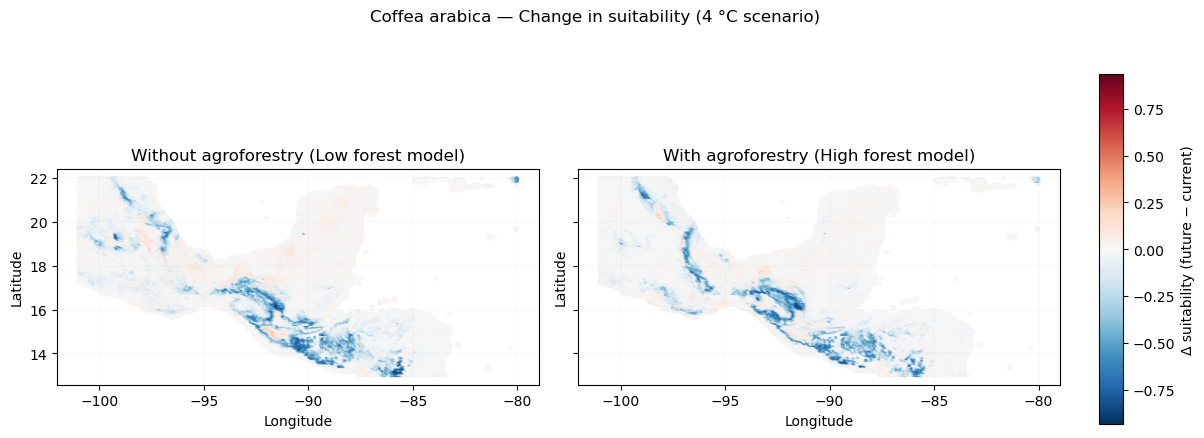

In [78]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# --- Labels (your keys) ---
sp_with_af  = "Coffea arabica — High forest"   # "with agroforestry"
sp_without  = "Coffea arabica — Low forest"    # "without agroforestry"

def make_delta_gdf(now_dict, fut_dict, species_label):
    """Merge current and future, compute delta = future - now, return GeoDataFrame."""
    df_now = now_dict[species_label].rename(columns={"suitability":"now"}).copy()
    df_fu  = fut_dict[species_label].rename(columns={"suitability":"fut"}).copy()
    df     = df_now.merge(df_fu[["lon","lat","fut"]], on=["lon","lat"], how="inner")
    df["delta"] = df["fut"] - df["now"]
    df["geometry"] = [Point(xy) for xy in zip(df["lon"], df["lat"])]
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# --- Build Δ for 2 °C and 4 °C ---
gdf_2c_with   = make_delta_gdf(suitability_maps_now, suitability_maps_future, sp_with_af)
gdf_2c_without= make_delta_gdf(suitability_maps_now, suitability_maps_future, sp_without)

gdf_4c_with   = make_delta_gdf(suitability_maps_now, suitability_maps_4c, sp_with_af)
gdf_4c_without= make_delta_gdf(suitability_maps_now, suitability_maps_4c, sp_without)

def plot_delta_pair(gdf_without, gdf_with, title_suffix):
    # same symmetric color scale for both panes
    vmax = np.nanmax(np.abs(np.r_[gdf_without["delta"].values, gdf_with["delta"].values]))
    vmin = -vmax

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

    for ax, gdf, subtitle in [
        (axes[0], gdf_without, "Without agroforestry (Low forest model)"),
        (axes[1], gdf_with,    "With agroforestry (High forest model)"),
    ]:
        sc = gdf.plot(
            ax=ax, column="delta", cmap="RdBu_r", vmin=vmin, vmax=vmax,
            markersize=5, alpha=0.7, legend=False
        )
        ax.set_title(subtitle)
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        ax.grid(True, linewidth=0.2, alpha=0.3)

    # single colorbar for both
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    mappable = plt.cm.ScalarMappable(cmap="RdBu_r")
    mappable.set_clim(vmin, vmax)
    cb = fig.colorbar(mappable, cax=cax)
    cb.set_label("Δ suitability (future − current)")

    fig.suptitle(f"Coffea arabica — Change in suitability ({title_suffix})", y=0.98)
    plt.tight_layout(rect=(0, 0, 0.9, 0.95))
    plt.show()

# --- Plot 2 °C and 4 °C comparisons ---
plot_delta_pair(gdf_2c_without, gdf_2c_with, "2 °C scenario")
plot_delta_pair(gdf_4c_without, gdf_4c_with, "4 °C scenario")


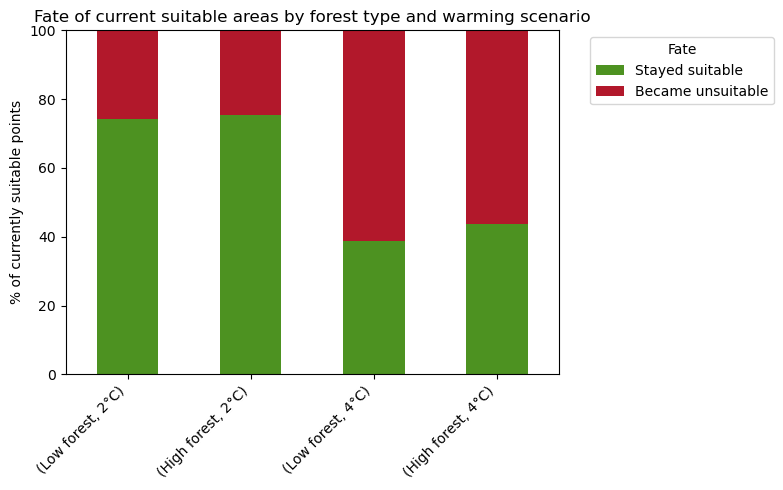

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Species keys
sp_low  = "Coffea arabica — Low forest"
sp_high = "Coffea arabica — High forest"

# Thresholds from current climate (keep fixed for both future scenarios)
thr_low  = suitability_maps_now[sp_low]["suitability"].mean()
thr_high = suitability_maps_now[sp_high]["suitability"].mean()

def suitable_fate(now_dict, fut_dict, key, thr):
    df_now = now_dict[key].rename(columns={"suitability":"now"}).copy()
    df_fu  = fut_dict[key].rename(columns={"suitability":"fut"}).copy()
    df     = df_now.merge(df_fu[["lon","lat","fut"]], on=["lon","lat"], how="inner")
    # Filter to currently suitable points
    df = df[df["now"] >= thr].copy()
    df["fate"] = ["Stayed suitable" if f >= thr else "Became unsuitable" for f in df["fut"]]
    return df["fate"].value_counts(normalize=True) * 100  # %

# Compute for both warming levels
fate_2c_low  = suitable_fate(suitability_maps_now, suitability_maps_future, sp_low, thr_low)
fate_2c_high = suitable_fate(suitability_maps_now, suitability_maps_future, sp_high, thr_high)

fate_4c_low  = suitable_fate(suitability_maps_now, suitability_maps_4c, sp_low, thr_low)
fate_4c_high = suitable_fate(suitability_maps_now, suitability_maps_4c, sp_high, thr_high)

# Combine into DataFrame
df_plot = pd.DataFrame({
    ("Low forest", "2°C"): fate_2c_low,
    ("High forest", "2°C"): fate_2c_high,
    ("Low forest", "4°C"): fate_4c_low,
    ("High forest", "4°C"): fate_4c_high
}).fillna(0)

# Reorder index (fate categories)
df_plot = df_plot.reindex(["Stayed suitable", "Became unsuitable"])

# Plot
colors = {"Stayed suitable": "#4d9221", "Became unsuitable": "#b2182b"}
df_plot.T.plot(kind="bar", stacked=True,
               color=[colors[c] for c in df_plot.index],
               figsize=(8,5))

plt.ylabel("% of currently suitable points")
plt.title("Fate of current suitable areas by forest type and warming scenario")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
plt.legend(title="Fate", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [85]:
fate_2c_high

fate
Stayed suitable      75.312134
Became unsuitable    24.687866
Name: proportion, dtype: float64

In [84]:
fate_2c_low

fate
Stayed suitable      74.335676
Became unsuitable    25.664324
Name: proportion, dtype: float64

In [82]:
sp_low  = "Coffea arabica — Low forest"
sp_high = "Coffea arabica — High forest"

# A) Are the NOW predictions numerically identical?
import numpy as np

arr_low_now  = suitability_maps_now[sp_low]["suitability"].to_numpy()
arr_high_now = suitability_maps_now[sp_high]["suitability"].to_numpy()

print("Same length:", len(arr_low_now) == len(arr_high_now))
print("All equal now?:", np.array_equal(arr_low_now, arr_high_now))
print("Max |diff| now:", np.max(np.abs(arr_low_now - arr_high_now)))

# B) Are the FUTURE predictions identical?
arr_low_2c  = suitability_maps_future[sp_low]["suitability"].to_numpy()
arr_high_2c = suitability_maps_future[sp_high]["suitability"].to_numpy()
print("All equal 2°C?:", np.array_equal(arr_low_2c, arr_high_2c))

# C) Are you pointing to the right keys?
print("Available classifier keys:", list(trained_classifiers.keys()))


Same length: True
All equal now?: False
Max |diff| now: 0.9166666666666666
All equal 2°C?: False
Available classifier keys: ['Coffea arabica — High forest', 'Coffea arabica — Low forest', 'Coffea arabica — All data']
